In [1]:
is_tfidf = True
is_symdiff = False
remove_stopwords = True
ns = {1: 100, 2: 500, 3: 1000, 4:2000}



In [2]:
import pickle
import time
import numpy
import urllib
import scipy.optimize
import random
from collections import defaultdict
from collections import Counter
import string
from sklearn import (
    linear_model,
    naive_bayes,
    svm,
    metrics,
    tree,
    neighbors,
    decomposition,
)
import ast
import importlib
import numpy as np
from scipy.spatial import distance
import random
import nltk
import pandas as pd
from nltk.corpus import stopwords

nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')

stop_words = [word for word in stopwords.words("english") if word != "not" and not ("n'" in word)]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kwkarlwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kwkarlwang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
import sys, os

sys.path.insert(0, os.path.abspath("../cse258_hw/"))



In [4]:
import as2_analysis_utils as as2_analysis
import as2_plot_utils as as2_plot

importlib.reload(as2_analysis)
importlib.reload(as2_plot)



<module 'as2_plot_utils' from '/Users/kwkarlwang/Desktop/Master/cse258/assignment2/as2_plot_utils.py'>

In [5]:
data_all = list(as2_analysis.parseData_line("renttherunway_final_data.json"))



In [6]:
def extract_features(data_all, key):
    """
    return data of particualr key
    """
    return [d[key] for d in data_all]



In [7]:
rating_all = extract_features(data_all, "rating")



In [8]:
null_count = [i == "null" for i in rating_all]



In [9]:
sum(null_count) / len(null_count)



0.0004258766827322586

In [10]:
fit_feedbadk = extract_features(data_all, "fit")



In [11]:
fit_feedbadk_freq = Counter(fit_feedbadk)



In [12]:
fit_feedbadk_prct = {key: val / len(data_all) for key, val in fit_feedbadk_freq.items()}



In [13]:
fit_feedbadk_prct


{'fit': 0.7377949975070633,
 'small': 0.13388628053847432,
 'large': 0.12831872195446237}

 # Count word frequency

In [14]:
# top words in fit reviews
fit_reviews_all = [
    d["review_text"] + " " + d["review_summary"] for d in data_all if d["fit"] == "fit"
]
small_reviews_all = [
    d["review_text"] + " " + d["review_summary"]
    for d in data_all
    if d["fit"] == "small"
]
large_reviews_all = [
    d["review_text"] + " " + d["review_summary"]
    for d in data_all
    if d["fit"] == "large"
]



In [15]:
def tokenize_data_sets(dataset, n=1):
    """
    Each item of dataset is a str
    """
    return [
        as2_analysis.tokenize_paragraph(
            d,
            n=n,
            remove_stopwrods=remove_stopwords,
            stopwords=stop_words
        )
        for d in dataset
    ]



In [16]:
# tokenize dataset
fit_tokenized_all = tokenize_data_sets(fit_reviews_all)
small_tokenized_all = tokenize_data_sets(small_reviews_all)
large_tokenized_all = tokenize_data_sets(large_reviews_all)



In [17]:
fit_word_count = as2_analysis.count_word_freq(fit_tokenized_all)
small_word_count = as2_analysis.count_word_freq(small_tokenized_all)
large_word_count = as2_analysis.count_word_freq(large_tokenized_all)


 # Get most frequent adjective

 Try bigram and trigram

In [18]:
def top_n_adj_n_gram(word_count_dict, adj_set=None):

    # if set of adj is given
    if adj_set:
        adj_count = {
            key: word_count_dict[key]
            for key in word_count_dict
            # if either of the word is an adj, preserve
            if key in adj_set
        }
    else:
        ## get the most common ajectives, might be slow
        adj_count = {
            key: word_count_dict[key]
            for key in word_count_dict
            # if either of the word is an adj, preserve
            if any(
                wordType[0] == "J"
                for _, wordType in nltk.pos_tag(key if type(key) == tuple else (key,))
            )
        }

    # sort them into pairs
    adj_count_pair = list(adj_count.items())

    # # sort
    adj_count_pair.sort(reverse=True, key=lambda x: x[1])

    return adj_count_pair



In [19]:
def top_adj_pipeline(fit_reviews_all, small_reviews_all, large_reviews_all, n=2):

    fit_tokenized_all = tokenize_data_sets(fit_reviews_all, n)
    small_tokenized_all = tokenize_data_sets(small_reviews_all, n)
    large_tokenized_all = tokenize_data_sets(large_reviews_all, n)

    fit_word_count = as2_analysis.count_word_freq(fit_tokenized_all)
    small_word_count = as2_analysis.count_word_freq(small_tokenized_all)
    large_word_count = as2_analysis.count_word_freq(large_tokenized_all)

    # all adj for fit, small, and large
    fit_adj, small_adj, large_adj = None, None, None

    # load if the pickle exists
    if os.path.exists(f"{n}-grams_adj"):
        with open(f"{n}-grams_adj", "rb") as f:
            fit_adj, small_adj, large_adj = pickle.load(f)

    start = time.time()
    top_fit_grams = top_n_adj_n_gram(fit_word_count, fit_adj)
    top_small_grams = top_n_adj_n_gram(small_word_count, small_adj)
    top_large_grams = top_n_adj_n_gram(large_word_count, large_adj)
    end = time.time()
    print(f"time consume: {end-start}s")
    return top_fit_grams, top_small_grams, top_large_grams



In [20]:
def write_adj_to_file(n):
    # get all the adj from the entire data
    top_fit_grams, top_small_grams, top_large_grams = top_adj_pipeline(
        fit_reviews_all, small_reviews_all, large_reviews_all, n
    )
    # make into sets
    a, b, c = (
        {word for word, _ in top_fit_grams},
        {word for word, _ in top_small_grams},
        {word for word, _ in top_large_grams},
    )
    # write to file
    with open(f"./{n}-grams_adj", "wb") as f:
        pickle.dump((a, b, c), f)



 # Feature Engineering

In [21]:
fit_data = [d for d in data_all if d["fit"] == "fit"]
small_data = [d for d in data_all if d["fit"] == "small"]
large_data = [d for d in data_all if d["fit"] == "large"]
data_balanced = random.sample(fit_data, k=len(large_data)) + small_data + large_data

In [22]:
random.shuffle(data_balanced)

In [23]:
data_size = len(data_balanced)
valid_percent = 0.2
test_percent = 0.2



In [24]:

data_train = data_balanced[: int(data_size * (1 - valid_percent - test_percent))]
data_valid = data_balanced[
    int(data_size * (1 - valid_percent - test_percent)) : int(
        data_size * (1 - test_percent)
    )
]
data_test = data_balanced[int(data_size * (1 - test_percent)) :]


In [25]:
def extract_review(data):
    fit_reviews = [
        d["review_text"] + " " + d["review_summary"] for d in data if d["fit"] == "fit"
    ]
    small_reviews = [
        d["review_text"] + " " + d["review_summary"]
        for d in data
        if d["fit"] == "small"
    ]
    large_reviews = [
        d["review_text"] + " " + d["review_summary"]
        for d in data
        if d["fit"] == "large"
    ]
    return fit_reviews, small_reviews, large_reviews



 Try n-gram BoW logistic regression/navie bayes

In [26]:
fit_reviews_train, small_reviews_train, large_reviews_train = extract_review(data_train)


In [27]:

top_word_set = set()
idf_score = {}
for n, threshold in ns.items():
    top_fit_grams, top_small_grams, top_large_grams = top_adj_pipeline(
        fit_reviews_train, small_reviews_train, large_reviews_train, n
    )

    a, b, c = (
        {word for word, _ in top_fit_grams[:threshold]},
        {word for word, _ in top_small_grams[:threshold]},
        ({word for word, _ in top_large_grams[:threshold]}),
    )
    if is_symdiff:
        top_gram = (a | b | c) - (a & b & c)
    else:
        top_gram = a | b | c
    if is_tfidf:
        idf_score.update(
            as2_analysis.calcualte_idf_score(
                top_gram,
                tokenize_data_sets(
                    fit_reviews_train + small_reviews_train + large_reviews_train, n
                ),
            )
        )
    print(f"unique top {n}-grams: {len(top_gram)}")
    top_word_set |= top_gram

print(f"unique top grams: {len(top_word_set)}")

wordId = dict(zip(top_word_set, range(len(top_word_set))))

time consume: 0.005688905715942383s
unique top 1-grams: 111
time consume: 0.12676501274108887s
unique top 2-grams: 789
time consume: 0.29502320289611816s
unique top 3-grams: 2071
time consume: 0.3715989589691162s
unique top 4-grams: 5326
unique top grams: 8297


In [28]:
def feature(d, ns=[1], is_tfidf=False):
    feat = [0] * len(top_word_set)
    review = d["review_text"] + " " + d["review_summary"]
    p_list = []
    for n in ns:
        p_list.extend(
            as2_analysis.tokenize_paragraph(
                review,
                n=n,
                remove_stopwrods=remove_stopwords,
                stopwords=stop_words
            )
        )
    for word in p_list:
        if word not in top_word_set:
            continue
        # use BoW for now
        feat[wordId[word]] += 1
    if is_tfidf:
        for word, score in idf_score.items():
            feat[wordId[word]] *= score

    return feat



In [29]:
def encode_output(data):
    return [labels[d["fit"]] for d in data]



In [30]:

labels = {"fit": 0, "small": 1, "large": 2}
X_train = [feature(d, ns, is_tfidf) for d in data_train]
y_train = encode_output(data_train)
X_valid = [feature(d, ns, is_tfidf) for d in data_valid]
y_valid = encode_output(data_valid)


 # Modeling

 Try the following numerous text classfication algorithm:
 
    - Navie Bayes
    - SVM
    - Logistic Regression
    - Decision Tree
    - KNN

In [31]:
models_data = {}

 ## Navie Bayes

Navie Bayes classifcation report



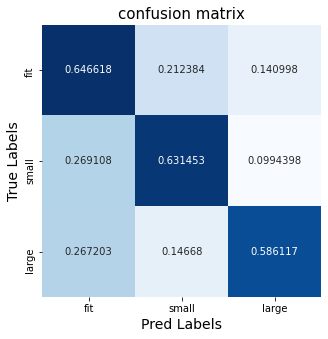

              precision    recall  f1-score   support

           0       0.55      0.65      0.59      5071
           1       0.64      0.63      0.63      4998
           2       0.71      0.59      0.64      4970

    accuracy                           0.62     15039
   macro avg       0.63      0.62      0.62     15039
weighted avg       0.63      0.62      0.62     15039




In [32]:
model = naive_bayes.MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print("Navie Bayes classifcation report\n")
as2_plot.plot_cm(
    metrics.confusion_matrix(y_valid, y_pred, normalize="true"), list(labels.keys())
)
print(metrics.classification_report(y_valid, y_pred))
print()
models_data["naive bayes"] = metrics.classification_report(
    y_valid, y_pred, output_dict=1
)


 Try dimensionality reduction for more time consuimg algorithm

In [33]:
svd = decomposition.TruncatedSVD(n_components=100)
X_train_reduce = svd.fit_transform(X_train)
X_valid_reduce = svd.transform(X_valid)


 ## Logistic Regression

Logistic Regression C=0.1, weights=None classifcation report



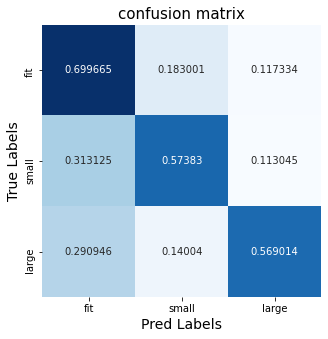

              precision    recall  f1-score   support

           0       0.54      0.70      0.61      5071
           1       0.64      0.57      0.60      4998
           2       0.71      0.57      0.63      4970

    accuracy                           0.61     15039
   macro avg       0.63      0.61      0.62     15039
weighted avg       0.63      0.61      0.62     15039


Logistic Regression C=0.1, weights=balanced classifcation report



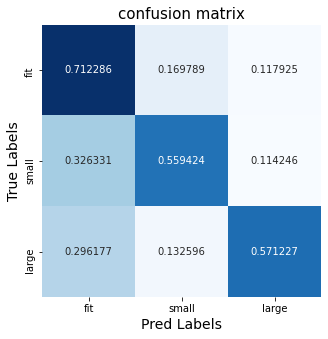

              precision    recall  f1-score   support

           0       0.54      0.71      0.61      5071
           1       0.65      0.56      0.60      4998
           2       0.71      0.57      0.63      4970

    accuracy                           0.61     15039
   macro avg       0.63      0.61      0.62     15039
weighted avg       0.63      0.61      0.62     15039


Logistic Regression C=1, weights=None classifcation report



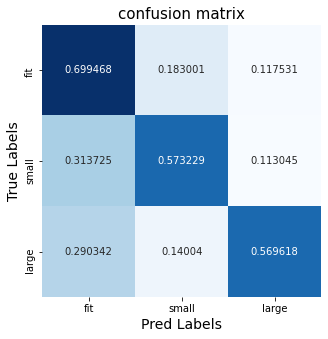

              precision    recall  f1-score   support

           0       0.54      0.70      0.61      5071
           1       0.64      0.57      0.60      4998
           2       0.71      0.57      0.63      4970

    accuracy                           0.61     15039
   macro avg       0.63      0.61      0.62     15039
weighted avg       0.63      0.61      0.62     15039


Logistic Regression C=1, weights=balanced classifcation report



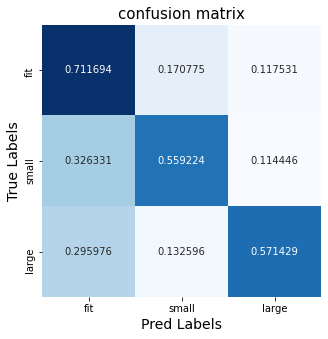

              precision    recall  f1-score   support

           0       0.54      0.71      0.61      5071
           1       0.65      0.56      0.60      4998
           2       0.71      0.57      0.63      4970

    accuracy                           0.61     15039
   macro avg       0.63      0.61      0.62     15039
weighted avg       0.63      0.61      0.62     15039


Logistic Regression C=10, weights=None classifcation report



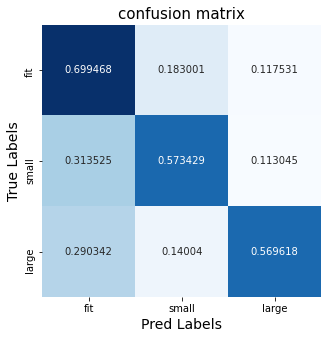

              precision    recall  f1-score   support

           0       0.54      0.70      0.61      5071
           1       0.64      0.57      0.60      4998
           2       0.71      0.57      0.63      4970

    accuracy                           0.61     15039
   macro avg       0.63      0.61      0.62     15039
weighted avg       0.63      0.61      0.62     15039


Logistic Regression C=10, weights=balanced classifcation report



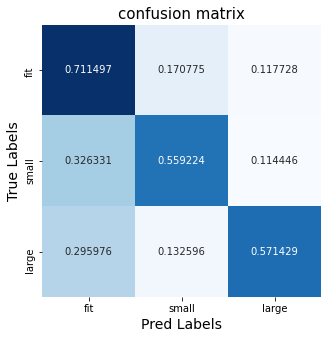

              precision    recall  f1-score   support

           0       0.54      0.71      0.61      5071
           1       0.65      0.56      0.60      4998
           2       0.71      0.57      0.63      4970

    accuracy                           0.61     15039
   macro avg       0.63      0.61      0.62     15039
weighted avg       0.63      0.61      0.61     15039


Logistic Regression C=100, weights=None classifcation report



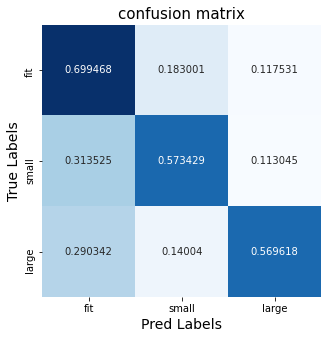

              precision    recall  f1-score   support

           0       0.54      0.70      0.61      5071
           1       0.64      0.57      0.60      4998
           2       0.71      0.57      0.63      4970

    accuracy                           0.61     15039
   macro avg       0.63      0.61      0.62     15039
weighted avg       0.63      0.61      0.62     15039


Logistic Regression C=100, weights=balanced classifcation report



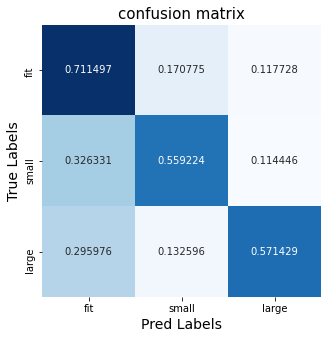

              precision    recall  f1-score   support

           0       0.54      0.71      0.61      5071
           1       0.65      0.56      0.60      4998
           2       0.71      0.57      0.63      4970

    accuracy                           0.61     15039
   macro avg       0.63      0.61      0.62     15039
weighted avg       0.63      0.61      0.61     15039




In [34]:

regs = [0.1, 1, 10,100]
weights = [None, 'balanced']
models = {
    f"C={reg}, weights={weight}": linear_model.LogisticRegression(
        C=reg, class_weight=weight
    )
    for reg in regs
    for weight in weights
}


for desc, model in models.items():
    model.fit(X_train_reduce, y_train)
    y_pred = model.predict(X_valid_reduce)
    print(f"Logistic Regression {desc} classifcation report\n")
    as2_plot.plot_cm(
        metrics.confusion_matrix(y_valid, y_pred, normalize="true"), list(labels.keys())
    )
    print(metrics.classification_report(y_valid, y_pred))
    print()
    models_data[f"logistic regression, {desc}"] = metrics.classification_report(
        y_valid, y_pred, output_dict=1
    )



## SVM

Try the following kernel:

    - linear
    - rbf
    - polynomial

In [35]:
# svd = decomposition.TruncatedSVD(n_components=50)
# X_train_reduce = svd.fit_transform(X_train)
# X_valid_reduce = svd.transform(X_valid)



SVM kernel=linear, C=0.1 classifcation report



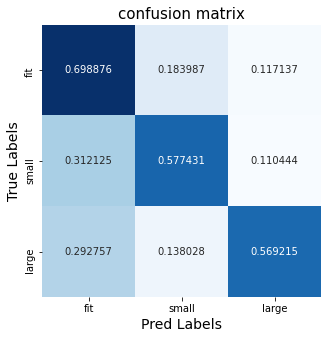

              precision    recall  f1-score   support

           0       0.54      0.70      0.61      5071
           1       0.64      0.58      0.61      4998
           2       0.71      0.57      0.63      4970

    accuracy                           0.62     15039
   macro avg       0.63      0.62      0.62     15039
weighted avg       0.63      0.62      0.62     15039


SVM kernel=linear, C=1 classifcation report



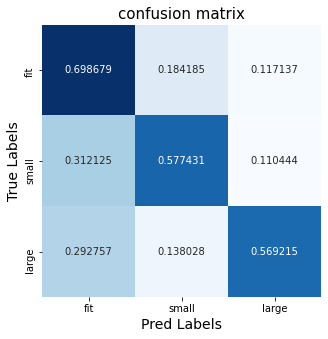

              precision    recall  f1-score   support

           0       0.54      0.70      0.61      5071
           1       0.64      0.58      0.61      4998
           2       0.71      0.57      0.63      4970

    accuracy                           0.62     15039
   macro avg       0.63      0.62      0.62     15039
weighted avg       0.63      0.62      0.62     15039


SVM kernel=linear, C=10 classifcation report



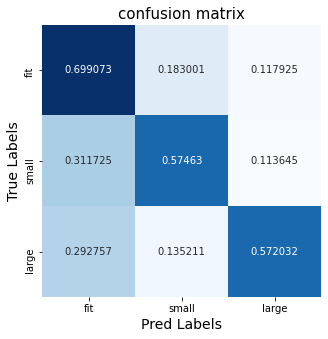

              precision    recall  f1-score   support

           0       0.54      0.70      0.61      5071
           1       0.64      0.57      0.61      4998
           2       0.71      0.57      0.63      4970

    accuracy                           0.62     15039
   macro avg       0.63      0.62      0.62     15039
weighted avg       0.63      0.62      0.62     15039




In [36]:

regs = [0.1, 1, 10]
models = {}
models.update({f"kernel=linear, C={reg}": svm.LinearSVC(C=reg) for reg in regs})
for desc, model in models.items():
    model.fit(X_train_reduce, y_train)
    y_pred = model.predict(X_valid_reduce)
    print(f"SVM {desc} classifcation report\n")
    as2_plot.plot_cm(
        metrics.confusion_matrix(y_valid, y_pred, normalize="true"), list(labels.keys())
    )
    print(metrics.classification_report(y_valid, y_pred))
    print()
    models_data[f"svm, {desc}"] = metrics.classification_report(
        y_valid, y_pred, output_dict=1
    )


In [37]:
# svd = decomposition.TruncatedSVD(n_components=100)
# X_train_reduce = svd.fit_transform(X_train)
# X_valid_reduce = svd.transform(X_valid)



 ## Decision Tree

Decision Tree max_depth=5 classifcation report



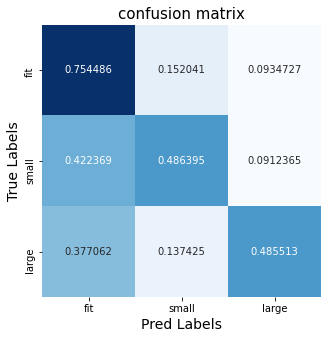

              precision    recall  f1-score   support

           0       0.49      0.75      0.59      5071
           1       0.63      0.49      0.55      4998
           2       0.72      0.49      0.58      4970

    accuracy                           0.58     15039
   macro avg       0.61      0.58      0.57     15039
weighted avg       0.61      0.58      0.57     15039


Decision Tree max_depth=10 classifcation report



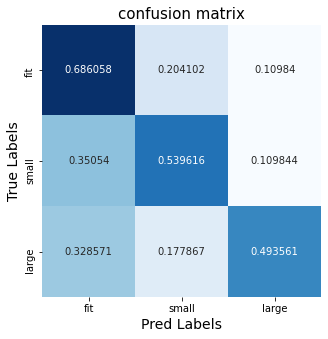

              precision    recall  f1-score   support

           0       0.51      0.69      0.58      5071
           1       0.58      0.54      0.56      4998
           2       0.69      0.49      0.58      4970

    accuracy                           0.57     15039
   macro avg       0.59      0.57      0.57     15039
weighted avg       0.59      0.57      0.57     15039


Decision Tree max_depth=20 classifcation report



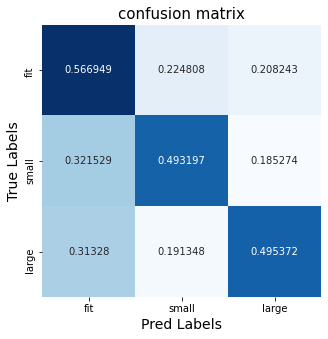

              precision    recall  f1-score   support

           0       0.48      0.57      0.52      5071
           1       0.54      0.49      0.52      4998
           2       0.55      0.50      0.52      4970

    accuracy                           0.52     15039
   macro avg       0.52      0.52      0.52     15039
weighted avg       0.52      0.52      0.52     15039


Decision Tree max_depth=50 classifcation report



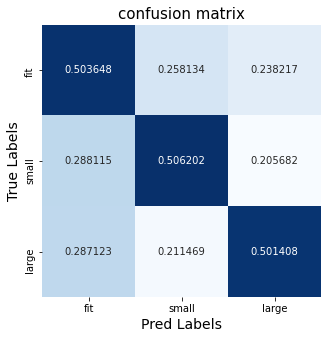

              precision    recall  f1-score   support

           0       0.47      0.50      0.49      5071
           1       0.52      0.51      0.51      4998
           2       0.53      0.50      0.51      4970

    accuracy                           0.50     15039
   macro avg       0.51      0.50      0.50     15039
weighted avg       0.50      0.50      0.50     15039




In [38]:
depths = [5, 10, 20, 50]
models = {
    f"max_depth={depth}": tree.DecisionTreeClassifier(max_depth=depth)
    for depth in depths
}


for desc, model in models.items():
    # delay?
    model.fit(X_train_reduce, y_train)
    y_pred = model.predict(X_valid_reduce)
    print(f"Decision Tree {desc} classifcation report\n")
    as2_plot.plot_cm(
        metrics.confusion_matrix(y_valid, y_pred, normalize="true"), list(labels.keys())
    )
    print(metrics.classification_report(y_valid, y_pred))
    print()
    models_data[f"decision tree, {desc}"] = metrics.classification_report(
        y_valid, y_pred, output_dict=1
    )



 ## K-nearest neighbor

KNN n-neighbor=20 classifcation report



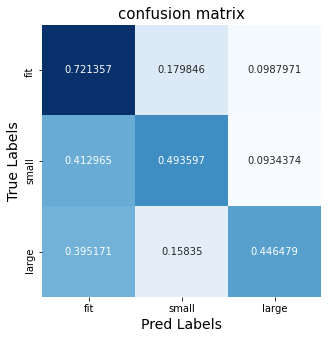

              precision    recall  f1-score   support

           0       0.48      0.72      0.57      5071
           1       0.59      0.49      0.54      4998
           2       0.70      0.45      0.54      4970

    accuracy                           0.55     15039
   macro avg       0.59      0.55      0.55     15039
weighted avg       0.59      0.55      0.55     15039


KNN n-neighbor=50 classifcation report



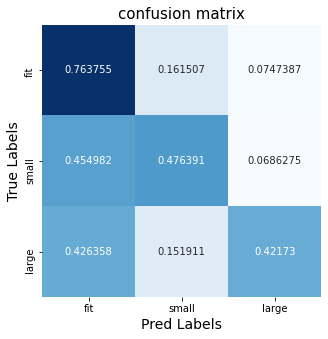

              precision    recall  f1-score   support

           0       0.47      0.76      0.58      5071
           1       0.60      0.48      0.53      4998
           2       0.74      0.42      0.54      4970

    accuracy                           0.56     15039
   macro avg       0.60      0.55      0.55     15039
weighted avg       0.60      0.56      0.55     15039


KNN n-neighbor=100 classifcation report



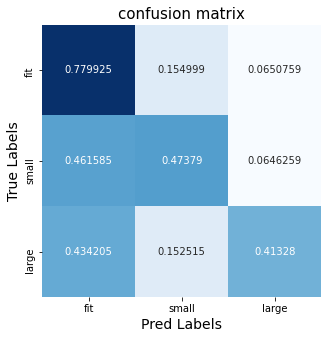

              precision    recall  f1-score   support

           0       0.47      0.78      0.59      5071
           1       0.61      0.47      0.53      4998
           2       0.76      0.41      0.54      4970

    accuracy                           0.56     15039
   macro avg       0.61      0.56      0.55     15039
weighted avg       0.61      0.56      0.55     15039


KNN n-neighbor=300 classifcation report



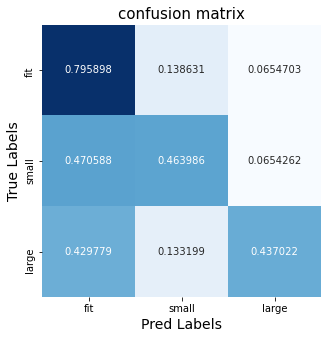

              precision    recall  f1-score   support

           0       0.47      0.80      0.59      5071
           1       0.63      0.46      0.53      4998
           2       0.77      0.44      0.56      4970

    accuracy                           0.57     15039
   macro avg       0.62      0.57      0.56     15039
weighted avg       0.62      0.57      0.56     15039




In [39]:
neighbor_nums = [20, 50, 100, 300]
models = {
    f"n-neighbor={neighbor_num}": neighbors.KNeighborsClassifier(
        n_neighbors=neighbor_num
    )
    for neighbor_num in neighbor_nums
}
for desc, model in models.items():
    model.fit(X_train_reduce, y_train)
    y_pred = model.predict(X_valid_reduce)
    print(f"KNN {desc} classifcation report\n")
    as2_plot.plot_cm(
        metrics.confusion_matrix(y_valid, y_pred, normalize="true"), list(labels.keys())
    )
    print(metrics.classification_report(y_valid, y_pred))
    print()
    models_data[f"knn, {desc}"] = metrics.classification_report(
        y_valid, y_pred, output_dict=1
    )



In [40]:
filename = ''
filename += 'sym_diff-' if is_symdiff else ''
filename += 'remove_stopwords-' if remove_stopwords else ''
filename += 'tfidf' if is_tfidf else 'count'
with open(f"./{filename}.pkl", "wb") as f:
        pickle.dump({'models': models_data, 'desc':filename}, f)